# Credit Risk Prediction

**Objective:** Classify loan applicants as *good* (no default) or *bad* (default).

*Author:* [Soumyadip Sarkar](https://soumyadipsarkar.in)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import shap, joblib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

from tab_transformer_pytorch import TabTransformer

sns.set_style("whitegrid")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## Load & Preview Data

Load the German Credit dataset from UCI and map the target:
$$
\text{TargetFlag} =
\begin{cases}
0, & \text{good (original code 1)},\\
1, & \text{bad  (original code 2)}.
\end{cases}
$$


In [2]:
cols = ["Status","Duration","CreditHistory","Purpose","CreditAmount",
        "Savings","Employment","InstallmentRate","PersonalStatus",
        "OtherDebtors","ResidenceDuration","Property","Age",
        "OtherInstallmentPlans","Housing","ExistingCredits",
        "Job","NumDependents","Telephone","ForeignWorker","Target"]

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
df = pd.read_csv(url, delim_whitespace=True, names=cols)
df["TargetFlag"] = (df["Target"] == 2).astype(int)

print("Shape:", df.shape)
print("Bad‐risk fraction:", df["TargetFlag"].mean().round(3))
df.head()

<ipython-input-2-8ed7243ef6f0>:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, names=cols)


Shape: (1000, 22)
Bad‐risk fraction: 0.3


,Status,Duration,CreditHistory,Purpose,CreditAmount,Savings,Employment,InstallmentRate,PersonalStatus,OtherDebtors,...,Age,OtherInstallmentPlans,Housing,ExistingCredits,Job,NumDependents,Telephone,ForeignWorker,Target,TargetFlag
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,67,A143,A152,2,A173,1,A192,A201,1,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,22,A143,A152,1,A173,1,A191,A201,2,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,49,A143,A152,1,A172,2,A191,A201,1,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,45,A143,A153,1,A173,2,A191,A201,1,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,53,A143,A153,2,A173,2,A191,A201,2,1


## Exploratory Data Analysis (EDA)

### Class Distribution

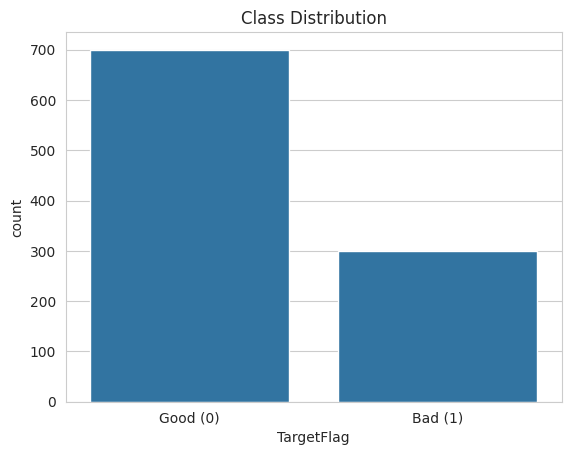

In [3]:
sns.countplot(x="TargetFlag", data=df)
plt.xticks([0,1], ["Good (0)","Bad (1)"])
plt.title("Class Distribution")
plt.show()

### Numeric Feature Distributions

Plot histograms for key numeric features.

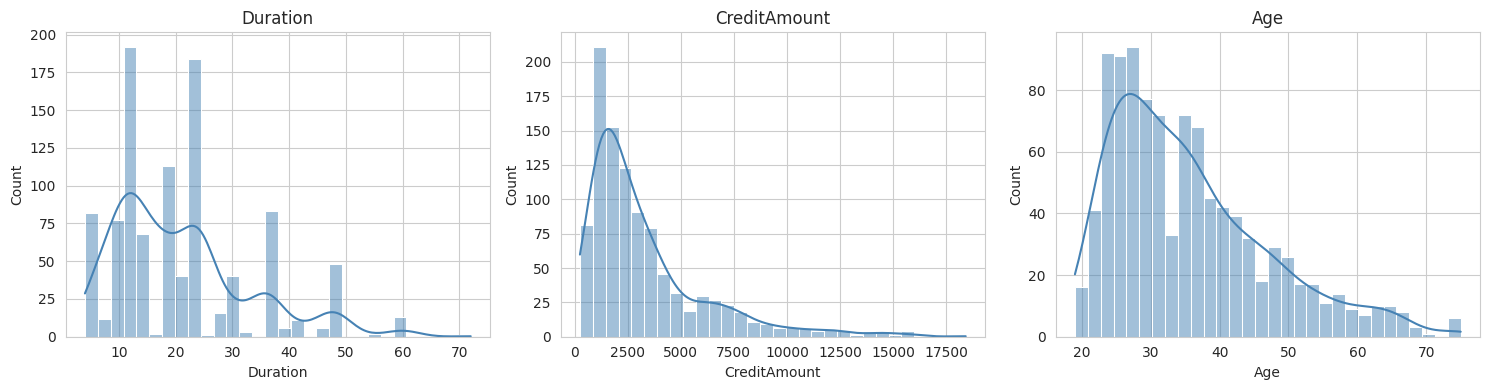

In [4]:
num_feats = ["Duration","CreditAmount","Age"]
fig, axs = plt.subplots(1,3,figsize=(15,4))
for ax, col in zip(axs, num_feats):
    sns.histplot(df[col], bins=30, kde=True, ax=ax, color="steelblue")
    ax.set_title(col)
plt.tight_layout()

### Correlation Heatmap

Visualize correlations among numeric features.

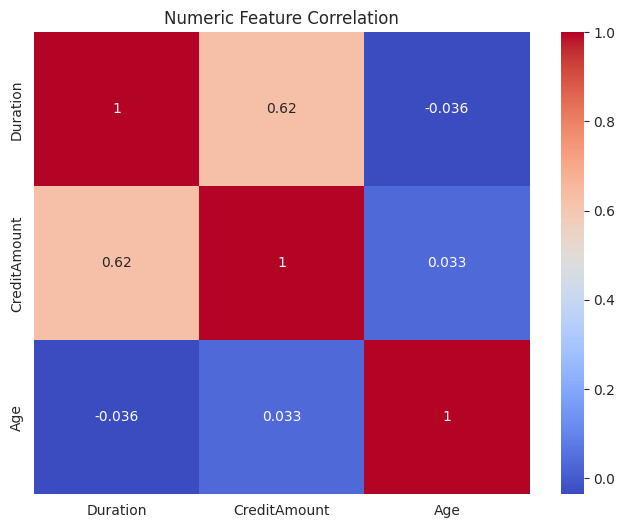

In [5]:
plt.figure(figsize=(8,6))
sns.heatmap(df[num_feats].corr(), annot=True, cmap="coolwarm")
plt.title("Numeric Feature Correlation")
plt.show()

## Feature Engineering

1. **Log‐transform** `CreditAmount`:  
   $\mathrm{LogCA} = \ln(1 + \mathrm{CreditAmount})$ to reduce skew.

2. **MonthlyPayment**:  
   $\mathrm{MP} = \mathrm{CreditAmount}/\mathrm{Duration}$.  

3. **Synthetic AnnualIncome & CreditLimit** (for enrichment):  
   - AnnualIncome ∼ Uniform[20 000, 80 000]  
   - CreditLimit  ∼ Uniform[5 000, 20 000]  

4. **Debt‐to‐Income (DTI)**: $\mathrm{DTI} = 12\cdot\mathrm{MP}/\mathrm{AnnualIncome}$.  

5. **Utilization**: $\mathrm{Util} = \mathrm{CreditAmount}/\mathrm{CreditLimit}$.

In [6]:
df["LogCreditAmount"] = np.log1p(df["CreditAmount"])
df["MonthlyPayment"] = df["CreditAmount"] / df["Duration"]

# Synthetic features
np.random.seed(42)
df["AnnualIncome"] = np.random.uniform(20000, 80000, size=len(df))
df["CreditLimit"]  = np.random.uniform(5000, 20000, size=len(df))

df["DTI"] = 12*df["MonthlyPayment"] / df["AnnualIncome"]
df["Utilization"] = df["CreditAmount"] / df["CreditLimit"]

df[["LogCreditAmount","MonthlyPayment","DTI","Utilization"]].describe()

,LogCreditAmount,MonthlyPayment,DTI,Utilization
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,7.789244,167.687020,0.047495,0.296974
std,0.776074,153.490959,0.047576,0.295928
min,5.525453,24.055556,0.004055,0.016026
25%,7.220008,89.600000,0.021365,0.114669
50%,7.749538,130.333333,0.034424,0.199591
75%,8.287340,206.183333,0.057336,0.371842
max,9.821464,2482.666667,0.790038,2.525418


## Encoding & Variance Filtering

One‐hot encode categoricals, then remove zero‐variance features ($\mathrm{Var}=0$) to prevent LightGBM warnings.


In [7]:
cat_cols = ["Status","CreditHistory","Purpose","Savings","Employment",
            "PersonalStatus","OtherDebtors","Property","OtherInstallmentPlans",
            "Housing","Telephone","ForeignWorker","Job"]

df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=False)
features = [c for c in df_enc if c not in ("Target","TargetFlag")]

X = df_enc[features].values.astype(np.float32)
y = df_enc["TargetFlag"].values

X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2,stratify=y,random_state=42
)

vt = VarianceThreshold()
X_train = vt.fit_transform(X_train)
X_test  = vt.transform(X_test)

print("Features after filtering:", X_train.shape[1])

Features after filtering: 67


## Handle Class Imbalance

Compute balanced class weights:
$$
w_j = \frac{n}{C\,n_j}
$$
with scikit-learn’s `compute_class_weight('balanced')`.

In [8]:
classes = np.unique(y_train)
wts = compute_class_weight("balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, wts))
print("Class weights:", class_weights)

Class weights: {np.int64(0): np.float64(0.7142857142857143), np.int64(1): np.float64(1.6666666666666667)}


## Model Comparison: XGBoost & LightGBM

- **XGBoost**: regularized gradient boosting with second‐order approximation.  
- **LightGBM**: leaf‐wise boosting, GOSS & EFB optimizations.
- **CatBoost**: handles categoricals natively.

We evaluate via stratified 5‐fold CV on F1, precision, recall.

In [9]:
cv = StratifiedKFold(5,shuffle=True,random_state=42)
scoring=["accuracy","precision","recall","f1"]

models = {
  "XGBoost": XGBClassifier(use_label_encoder=False,eval_metric="logloss",random_state=42),
  "LightGBM":LGBMClassifier(class_weight="balanced",random_state=42),
  "CatBoost":CatBoostClassifier(iterations=200,verbose=0,
                                class_weights=[wts[0],wts[1]])
}

results = {}
for name,mdl in models.items():
    cvres=cross_validate(mdl,X_train,y_train,cv=cv,scoring=scoring,n_jobs=-1)
    results[name] = {m:cvres[f"test_{m}"].mean().round(3) for m in scoring}

pd.DataFrame(results).T

,accuracy,precision,recall,f1
XGBoost,0.739,0.592,0.462,0.514
LightGBM,0.729,0.547,0.538,0.539
CatBoost,0.744,0.573,0.600,0.583


## TabTransformer

TabTransformer uses multi-head self-attention over categorical embeddings.

In [10]:
# Prepare categorical & continuous inputs
Xc = df[cat_cols].apply(lambda col: col.astype("category").cat.codes).values
cont = df[["Duration","CreditAmount","Age","LogCreditAmount",
           "MonthlyPayment","DTI","Utilization"]].values.astype(np.float32)

Xc_tr, Xc_te, cont_tr, cont_te, yt_tr, yt_te = train_test_split(
    Xc, cont, y, test_size=0.2,stratify=y,random_state=42
)

card = [len(df[c].unique()) for c in cat_cols]
tt = TabTransformer(
    categories=tuple(card), num_continuous=cont_tr.shape[1],
    dim=32, depth=4, heads=8, attn_dropout=0.1, ff_dropout=0.1
).to(device)

# DataLoader
ts = WeightedRandomSampler([class_weights[v] for v in yt_tr], len(yt_tr), True)
ds = TensorDataset(torch.tensor(Xc_tr).long(),
                   torch.tensor(cont_tr).float(),
                   torch.tensor(yt_tr).float())
ldr = DataLoader(ds, batch_size=256, sampler=ts)

opt = optim.AdamW(tt.parameters(),lr=1e-5)
sch = OneCycleLR(opt, max_lr=1e-3,
                steps_per_epoch=len(ldr), epochs=100)
loss_fn=nn.BCEWithLogitsLoss()

for ep in range(1,101):
    tt.train()
    tl=0
    for xc,xcnt,yb in ldr:
        xc,xcnt,yb=xc.to(device),xcnt.to(device),yb.to(device)
        opt.zero_grad()
        out=tt(xc,xcnt).squeeze()
        loss=loss_fn(out,yb)
        loss.backward()
        opt.step()
        sch.step()
        tl+=loss.item()*len(yb)
    print(f"Epoch {ep:03d}|Loss {tl/len(ldr.dataset):.4f}")

# Evaluate
tt.eval()
with torch.no_grad():
    preds = torch.sigmoid(tt(torch.tensor(Xc_te).long().to(device),
                             torch.tensor(cont_te).float().to(device)).squeeze()).cpu().numpy()
bin = (preds>=0.5).astype(int)
results["TabTransformer"] = {
    "accuracy":round(accuracy_score(yt_te,bin), 3),
    "precision":round(precision_score(yt_te,bin), 3),
    "recall":round(recall_score(yt_te,bin), 3),
    "f1":round(f1_score(yt_te,bin), 3)
}

Epoch 001|Loss 0.6817
Epoch 002|Loss 0.6226
Epoch 003|Loss 0.5879
Epoch 004|Loss 0.5319
Epoch 005|Loss 0.5073
Epoch 006|Loss 0.4940
Epoch 007|Loss 0.5020
Epoch 008|Loss 0.4759
Epoch 009|Loss 0.4353
Epoch 010|Loss 0.4584
Epoch 011|Loss 0.4552
Epoch 012|Loss 0.4262
Epoch 013|Loss 0.3787
Epoch 014|Loss 0.3624
Epoch 015|Loss 0.4001
Epoch 016|Loss 0.3112
Epoch 017|Loss 0.2735
Epoch 018|Loss 0.3568
Epoch 019|Loss 0.2414
Epoch 020|Loss 0.2165
Epoch 021|Loss 0.2107
Epoch 022|Loss 0.2453
Epoch 023|Loss 0.1921
Epoch 024|Loss 0.1667
Epoch 025|Loss 0.1675
Epoch 026|Loss 0.1443
Epoch 027|Loss 0.2077
Epoch 028|Loss 0.1739
Epoch 029|Loss 0.2851
Epoch 030|Loss 0.1878
Epoch 031|Loss 0.1644
Epoch 032|Loss 0.1809
Epoch 033|Loss 0.1008
Epoch 034|Loss 0.0761
Epoch 035|Loss 0.0723
Epoch 036|Loss 0.0618
Epoch 037|Loss 0.0447
Epoch 038|Loss 0.0503
Epoch 039|Loss 0.0809
Epoch 040|Loss 0.0727
Epoch 041|Loss 0.0600
Epoch 042|Loss 0.1281
Epoch 043|Loss 0.0989
Epoch 044|Loss 0.1213
Epoch 045|Loss 0.0759
Epoch 046|

## Hyperparameter Tuning: XGBoost, LightGBM, CatBoost

Search over `n_estimators, max_depth, learning_rate, subsample, colsample_bytree` to maximize F1.

In [11]:
param_dist = {
    "n_estimators":[100,200,300],
    "max_depth":[3,4,5],
    "learning_rate":[0.01,0.05,0.1],
    "subsample":[0.7,0.8,1.0],
    "colsample_bytree":[0.7,0.8,1.0]
}
search = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    param_dist, scoring="f1", n_iter=10, cv=cv,
    random_state=42, n_jobs=-1, verbose=1
)
search.fit(X_train, y_train)
best_xgb = search.best_estimator_
print("Best XGBoost CV F1:", search.best_score_.round(3))

lgb_param_dist = {
    "num_leaves": [15, 31, 63],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 300],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

lgbm = LGBMClassifier(class_weight="balanced", random_state=42)
lgbm_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgb_param_dist,
    n_iter=20,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)
lgbm_search.fit(X_train, y_train)
print("Best LightGBM CV F1:", round(lgbm_search.best_score_, 3))

cb_param_dist = {
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.03, 0.1],
    "iterations": [100, 200, 300],
    "l2_leaf_reg": [1, 3, 5],
    "bagging_temperature": [0.5, 1, 2]
}

cb = CatBoostClassifier(iterations=200,verbose=0,
                                class_weights=[wts[0],wts[1]])
cb_search = RandomizedSearchCV(
    estimator=cb,
    param_distributions=cb_param_dist,
    n_iter=20,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)
cb_search.fit(X_train, y_train)
print("Best CatBoost CV F1:", round(cb_search.best_score_, 3))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:08:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost CV F1: 0.518
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 240, number of negative: 560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1974
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

## Evaluate Tuned XGBoost, LightGBM, CatBoost on Test Set

Report metrics and plot confusion matrix.

In [12]:
y_xgb = best_xgb.predict(X_test)
print("XGBoost Test Metrics:")
print(f"Accuracy:{accuracy_score(y_test,y_xgb):.3f}")
print(f"Precision:{precision_score(y_test,y_xgb):.3f}")
print(f"Recall:{recall_score(y_test,y_xgb):.3f}")
print(f"F1:{f1_score(y_test,y_xgb):.3f}")

best_lgbm = lgbm_search.best_estimator_
y_lgbm = best_lgbm.predict(X_test)
print("\nLightGBM Test Metrics:")
print(" Accuracy:", round(accuracy_score(y_test, y_lgbm), 3))
print(" Precision:", round(precision_score(y_test, y_lgbm), 3))
print(" Recall:", round(recall_score(y_test, y_lgbm), 3))
print(" F1:", round(f1_score(y_test, y_lgbm), 3))

best_cb = cb_search.best_estimator_
y_cb = best_cb.predict(X_test)
print("\nCatBoost Test Metrics:")
print(" Accuracy:", round(accuracy_score(y_test, y_cb), 3))
print(" Precision:", round(precision_score(y_test, y_cb), 3))
print(" Recall:", round(recall_score(y_test, y_cb), 3))
print(" F1:", round(f1_score(y_test, y_cb), 3))

XGBoost Test Metrics:
Accuracy:0.775
Precision:0.667
Recall:0.500
F1:0.571

LightGBM Test Metrics:
 Accuracy: 0.73
 Precision: 0.537
 Recall: 0.717
 F1: 0.614

CatBoost Test Metrics:
 Accuracy: 0.71
 Precision: 0.512
 Recall: 0.733
 F1: 0.603


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


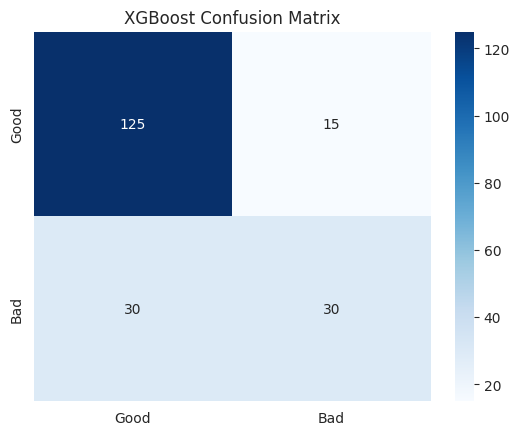

In [13]:
cm = confusion_matrix(y_test,y_xgb)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",
            xticklabels=["Good","Bad"], yticklabels=["Good","Bad"])
plt.title("XGBoost Confusion Matrix")
plt.show()

## Final Evaluation & Comparison

Gather test‐set metrics for all models.

In [14]:
# XGBoost, LightGBM, CatBoost
for name,mdl in models.items():
    mdl.fit(X_train,y_train)
    ypred=mdl.predict(X_test)
    print(name,round(accuracy_score(y_test,ypred), 3),
          round(precision_score(y_test,ypred), 3),
          round(recall_score(y_test,ypred), 3),
          round(f1_score(y_test,ypred), 3))

# TabTransformer
print("TabTransformer",results["TabTransformer"])

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:11:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


XGBoost 0.775 0.683 0.467 0.554
[LightGBM] [Info] Number of positive: 240, number of negative: 560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1974
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CatBoost 0.78 0.621 0.683 0.651
TabTransformer {'accuracy': 0.715, 'precision': 0.527, 'recall': 0.483, 'f1': 0.504}


## Model Interpretation with SHAP

Use `shap.TreeExplainer` for XGBoost. SHAP values satisfy:
$$
f(x)=\phi_0+\sum_i\phi_i,\quad
\phi_i=\sum_{S\subseteq N\setminus\{i\}}\frac{|S|!(n-|S|-1)!}{n!}[f_{S\cup\{i\}}-f_S],
$$
ensuring local accuracy and consistency.

<ipython-input-15-8e6b34be00cc>:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, X_test, plot_type="bar")


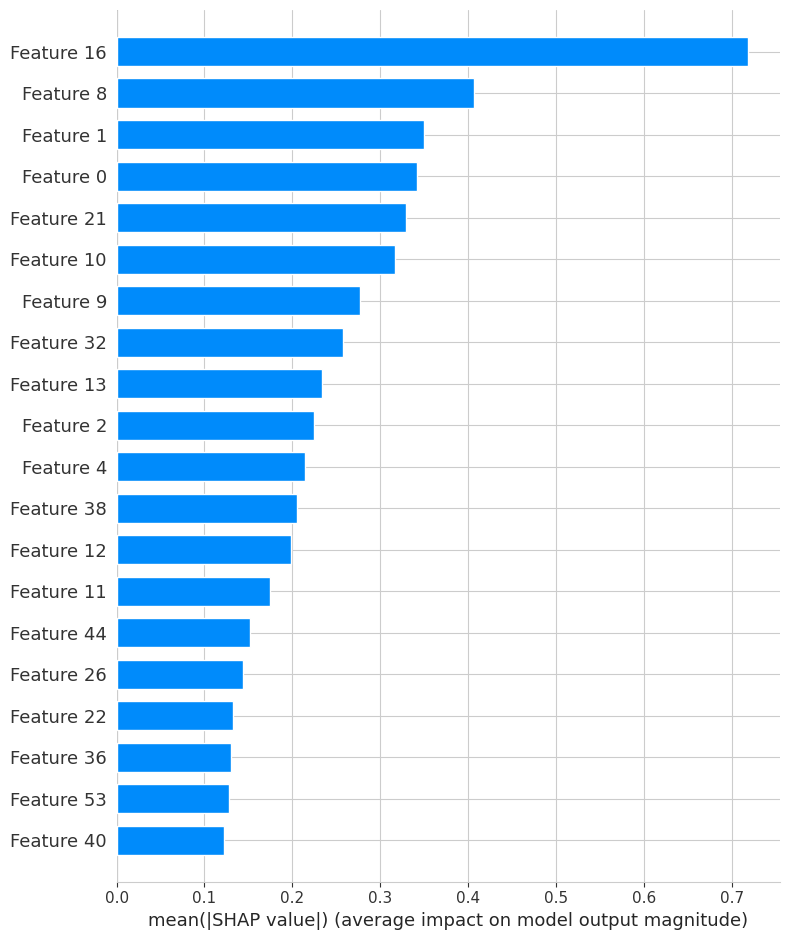

In [15]:
expl = shap.TreeExplainer(best_xgb)
sv = expl.shap_values(X_test)
shap.summary_plot(sv, X_test, plot_type="bar")

## Threshold Optimization

Find $\tau$ maximizing
$\mathrm{F1}(\tau)=2\frac{P(\tau)R(\tau)}{P(\tau)+R(\tau)}$ on validation scores.

In [16]:
probs = best_xgb.predict_proba(X_test)[:,1]
prec, rec, th = precision_recall_curve(y_test, probs)
f1s = 2*prec*rec/(prec+rec+1e-8)
opt = th[np.argmax(f1s)]
print(f"Optimal τ={opt:.3f}, F1={max(f1s):.3f}")

Optimal τ=0.448, F1=0.619


## Fairness Checks

Compute **Demographic Parity** and **Equal Opportunity** for `ForeignWorker`:
$$
\Delta DP=|P(\hat Y=1|A=0)-P(\hat Y=1|A=1)|,\quad
\Delta EO=|\mathrm{TPR}(A=0)-\mathrm{TPR}(A=1)|.
$$

In [17]:
df_test = pd.DataFrame(X_test, columns=vt.get_feature_names_out())
df_test["y_true"]=y_test; df_test["y_pred"]=(probs>=opt).astype(int)

fw_vals = df_enc["ForeignWorker_A201"].values[-len(y_test):]
df_test["fw"] = fw_vals

gp = df_test.groupby("fw")
dp = abs(gp["y_pred"].mean().diff().iloc[-1])
eo = abs(gp.apply(lambda g: recall_score(g.y_true,g.y_pred)).diff().iloc[-1])
print(f"ΔDP={dp:.3f}, ΔEO={eo:.3f}")

ΔDP=0.142, ΔEO=0.179


<ipython-input-17-180a53fc38a0>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eo = abs(gp.apply(lambda g: recall_score(g.y_true,g.y_pred)).diff().iloc[-1])


## Manual Rule‐Based Flags

From SHAP, top features: `Status_A14`, `MonthlyPayment`, `LogCreditAmount`.  
Rule:
$$
f(x)=\mathbf{1}(x_{\mathrm{Status\_A14}}=1\vee x_{\mathrm{MonthlyPayment}}>1000\vee x_{\mathrm{LogCreditAmount}}>\ln(5001)).
$$

In [18]:
idx_s14 = list(df_enc.columns).index("Status_A14")
idx_mp = list(df_enc.columns).index("MonthlyPayment")
idx_lca= list(df_enc.columns).index("LogCreditAmount")

def rule(row):
    return int((row[idx_s14]==1) or (row[idx_mp]>1000) or (row[idx_lca]>np.log1p(5000)))

df_test["rule"] = [rule(r) for r in X_test]
print("Rule Recall:", round(recall_score(df_test.y_true,df_test.rule), 3))
print("Rule Precision:",round(precision_score(df_test.y_true,df_test.rule), 3))

Rule Recall: 1.0
Rule Precision: 0.3


## Save Models

Persist PyTorch MLP, XGBoost, and LightGBM for production.

In [19]:
torch.save(tt.state_dict(), "tabtransformer_state_dict.pt")
print("TabTransformer state_dict saved to tabtransformer_state_dict.pt")
torch.save(tt, "tabtransformer_full_model.pt")
print("Full TabTransformer model saved to tabtransformer_full_model.pt")
joblib.dump(models["XGBoost"], "xgb.pkl")
joblib.dump(models["LightGBM"], "lgbm.pkl")
joblib.dump(models["CatBoost"], "cb.pkl")
print("Models saved: xgb.pkl, lgbm.pkl, cb.pkl")

TabTransformer state_dict saved to tabtransformer_state_dict.pt
Full TabTransformer model saved to tabtransformer_full_model.pt
Models saved: xgb.pkl, lgbm.pkl, cb.pkl
